In [ ]:
!pip install datasets

!pip install transformers==4.25.1 torch==1.13.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.9/93.9 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 92.9 MB/s eta 0:00:00
   

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from transformers import AutoTokenizer, GPT2ForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
import pandas as pd
from datasets import Dataset
import torch

In [ ]:
# wandb'yi devre dışı bırak
os.environ["WANDB_DISABLED"] = "true"

# Google Drive'ı bağlama
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Eğitim ve test veri setlerini yükleme
train_file_path = "/content/drive/MyDrive/30_data_set/30_train/sorted_final_merged_train.xlsx"
test_file_path = "/content/drive/MyDrive/30_data_set/30_test/sorted_final_merged_test.xlsx"

train_data = pd.read_excel(train_file_path).dropna()
test_data = pd.read_excel(test_file_path).dropna()

# Eğitim ve test veri setlerini DataFrame formatına dönüştürme
train_df = pd.DataFrame({"text": train_data['poem_text'], "label": train_data['label']})
test_df = pd.DataFrame({"text": test_data['poem_text'], "label": test_data['label']})

# Dataset formatına dönüştürme
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [ ]:
# Model ve tokenizer yükleme (GPT-2)
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenizer ayarları (padding token tanımlama)
tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
# GPT-2 modelini sınıflandırma için uyarlama
model = GPT2ForSequenceClassification.from_pretrained(
    model_name,
    num_labels=train_data['label'].nunique()
)

# GPU kontrolü ve cihaz seçimi
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Tokenizasyon fonksiyonu
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=512
    )

# Tokenizasyon işlemi
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Modelin etiketleri kullanabilmesi için label formatını güncelleme
def format_labels(examples):
    examples["labels"] = examples["label"]
    return examples

train_dataset = train_dataset.map(format_labels, batched=True)
test_dataset = test_dataset.map(format_labels, batched=True)


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/11482 [00:00<?, ? examples/s]

Map:   0%|          | 0/4916 [00:00<?, ? examples/s]

Map:   0%|          | 0/11482 [00:00<?, ? examples/s]

Map:   0%|          | 0/4916 [00:00<?, ? examples/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using cuda_amp half precision backend
The following columns in the training set don't have a corresponding argument in `GPT2ForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `GPT2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 11482
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumul

Epoch,Training Loss,Validation Loss
1,1.278700,1.231511
2,0.912200,1.021064
3,0.829100,0.851974
4,0.726100,0.858684
5,0.678000,0.802074
6,0.599600,0.804394
7,0.644900,0.806481


The following columns in the evaluation set don't have a corresponding argument in `GPT2ForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `GPT2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 4916
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-718
Configuration saved in ./results/checkpoint-718/config.json
Model weights saved in ./results/checkpoint-718/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-718/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-718/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `GPT2ForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `GPT2ForSequenceClassification.forward`,  you can safely ignore this message.
***

Eğitim süresi: 992.98 saniye


Model weights saved in ./best_model/pytorch_model.bin
tokenizer config file saved in ./best_model/tokenizer_config.json
Special tokens file saved in ./best_model/special_tokens_map.json
tokenizer config file saved in ./best_model/tokenizer_config.json
Special tokens file saved in ./best_model/special_tokens_map.json


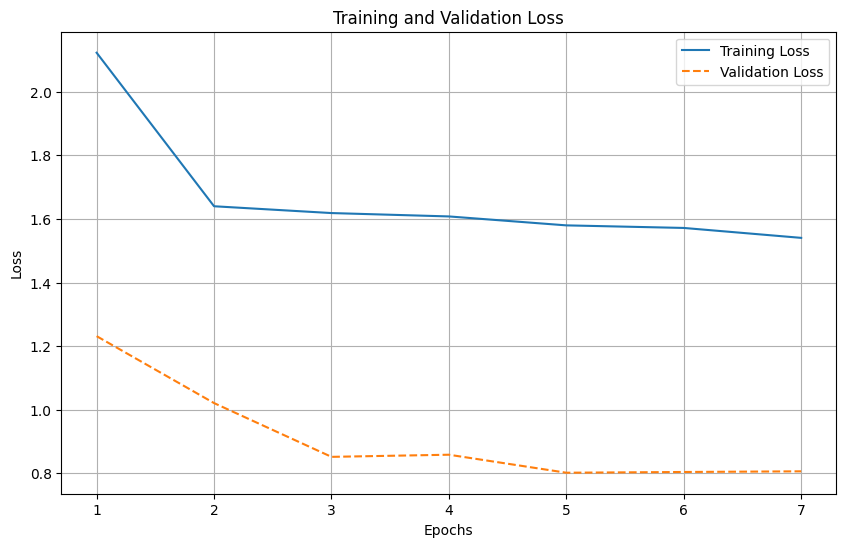

In [ ]:
# GPT-2 Tokenizer ayarları
tokenizer.pad_token = tokenizer.eos_token

# GPT-2 Model konfigürasyonu
model.config.pad_token_id = tokenizer.pad_token_id


# Eğitim ayarları
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    fp16=True,  # Mixed precision training
    logging_dir="./logs",
    logging_steps=50,
    learning_rate=1e-5
)

# Eğitim süresi ölçümü
start_training_time = time.time()

# Trainer oluşturma
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# Model eğitimi
training_logs = trainer.train()

# Eğitim süresini ölçme
end_training_time = time.time()
total_training_time = end_training_time - start_training_time
print(f"Eğitim süresi: {total_training_time:.2f} saniye")

# Modeli kaydetme
trainer.save_model("./best_model")
tokenizer.save_pretrained("./best_model")

# Eğitim ve doğrulama loss grafikleri
log_history = trainer.state.log_history
train_losses = [log["loss"] for log in log_history if "loss" in log]
val_losses = [log["eval_loss"] for log in log_history if "eval_loss" in log]

# Minimum uzunluğu bul
min_length = min(len(train_losses), len(val_losses))

# Epochs aralığını minimum uzunluğa göre ayarla
epochs = range(1, min_length + 1)

# Grafikleri çizin
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses[:min_length], label="Training Loss")
plt.plot(epochs, val_losses[:min_length], label="Validation Loss", linestyle="--")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()

# Çıkarım süresi ölçümü
inference_start_time = time.time()

The following columns in the test set don't have a corresponding argument in `GPT2ForSequenceClassification.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `GPT2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 4916
  Batch size = 16


Çıkarım süresi: 56.99 saniye
Confusion Matrix:
 [[815  40  31  43  55]
 [ 30 792  67  24  68]
 [ 56 142 543  71 172]
 [ 60  31  76 712 105]
 [ 53  61  78  72 719]]


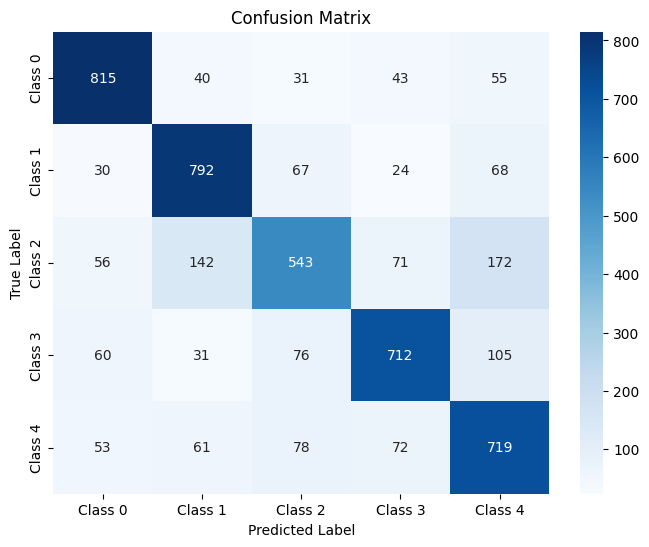

Accuracy: 0.7284377542717657
              precision    recall  f1-score   support

     Class 0       0.80      0.83      0.82       984
     Class 1       0.74      0.81      0.77       981
     Class 2       0.68      0.55      0.61       984
     Class 3       0.77      0.72      0.75       984
     Class 4       0.64      0.73      0.68       983

    accuracy                           0.73      4916
   macro avg       0.73      0.73      0.73      4916
weighted avg       0.73      0.73      0.73      4916

Sensitivity ve Specificity Sonuçları: {'Class 0': {'Sensitivity': 0.8282520325203252, 'Specificity': 0.9493896236012207}, 'Class 1': {'Sensitivity': 0.8073394495412844, 'Specificity': 0.9303684879288437}, 'Class 2': {'Sensitivity': 0.551829268292683, 'Specificity': 0.9359104781281791}, 'Class 3': {'Sensitivity': 0.7235772357723578, 'Specificity': 0.9465920651068158}, 'Class 4': {'Sensitivity': 0.7314343845371313, 'Specificity': 0.8982964658021866}}


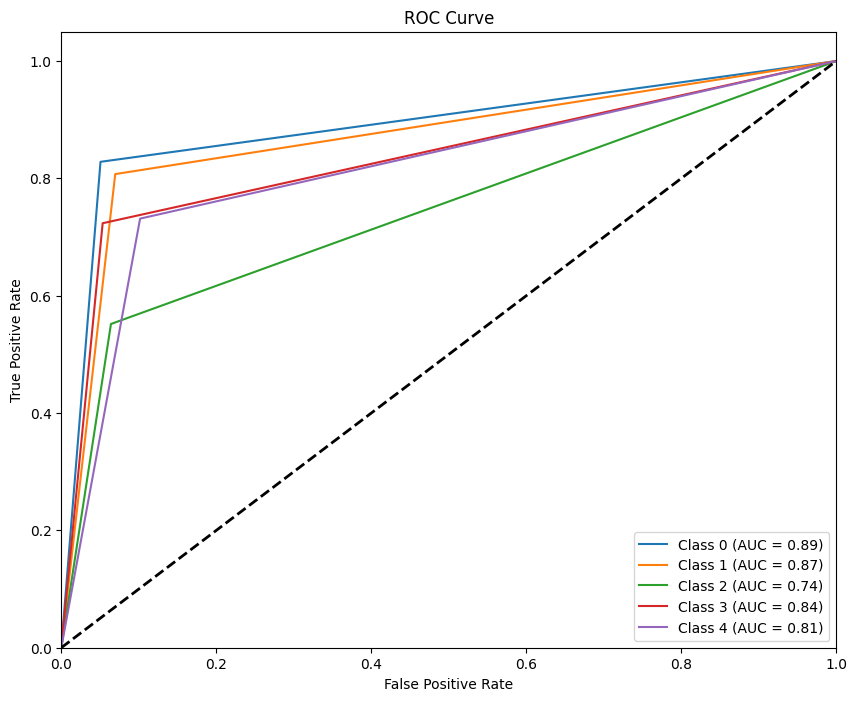

Macro AUC: 0.8302989491231028


In [ ]:
# Modeli test moduna al
model.eval()

# Tahminleri alma
predictions, labels, _ = trainer.predict(test_dataset)

inference_end_time = time.time()
inference_time = inference_end_time - inference_start_time
print(f"Çıkarım süresi: {inference_time:.2f} saniye")

# Gerçek ve tahmin edilen etiketleri al
true_labels = labels
predictions = np.argmax(predictions, axis=1)

# Confusion Matrix oluşturma
cm = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:\n", cm)

# Confusion Matrix görselleştirme
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[f'Class {i}' for i in range(cm.shape[0])], yticklabels=[f'Class {i}' for i in range(cm.shape[0])])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Accuracy hesaplama
accuracy = np.trace(cm) / float(np.sum(cm))
print("Accuracy:", accuracy)

# Precision, Recall, F-Score gibi metrikler
report = classification_report(true_labels, predictions, target_names=[f'Class {i}' for i in range(len(np.unique(true_labels)))] )
print(report)

# Sensitivity ve Specificity hesaplama
def compute_sensitivity_specificity(cm):
    metrics = {}
    for i in range(len(cm)):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = cm.sum() - (TP + FN + FP)
        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        metrics[f"Class {i}"] = {"Sensitivity": sensitivity, "Specificity": specificity}
    return metrics

sensitivity_specificity = compute_sensitivity_specificity(cm)
print("Sensitivity ve Specificity Sonuçları:", sensitivity_specificity)

# AUC (Area Under Curve) hesaplama
classes = np.unique(true_labels)
y_true_binary = label_binarize(true_labels, classes=classes)
y_pred_binary = label_binarize(predictions, classes=classes)

# AUC ve ROC eğrisi için değerleri hesaplama
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_true_binary[:, i], y_pred_binary[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC Eğrisini Çizme
plt.figure(figsize=(10, 8))
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], label=f"Class {classes[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# Ortalama AUC Hesaplama
macro_auc = roc_auc_score(y_true_binary, y_pred_binary, average="macro")
print("Macro AUC:", macro_auc)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Google Drive'a kayıt yolu
model_save_path = "/content/drive/MyDrive/best_gpt2_trained_model"

# Modeli ve tokenizer'ı kaydetme
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"Model ve tokenizer başarıyla {model_save_path} dizinine kaydedildi.")


Configuration saved in /content/drive/MyDrive/best_gpt2_trained_model/config.json


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Model weights saved in /content/drive/MyDrive/best_gpt2_trained_model/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/best_gpt2_trained_model/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/best_gpt2_trained_model/special_tokens_map.json


Model ve tokenizer başarıyla /content/drive/MyDrive/best_gpt2_trained_model dizinine kaydedildi.


In [ ]:
from transformers import AutoTokenizer, GPT2ForSequenceClassification
import torch

# Modeli ve tokenizer'ı Google Drive'dan yükleme
model_load_path = "/content/drive/MyDrive/best_gpt2_trained_model"
tokenizer = AutoTokenizer.from_pretrained(model_load_path)
model = GPT2ForSequenceClassification.from_pretrained(model_load_path)

# Cihaz seçimi (GPU varsa kullanılır)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()  # Modeli değerlendirme moduna al

# Tahmin fonksiyonu
def predict_poem_category(poem_text):
    # Şiiri tokenize et
    inputs = tokenizer(
        poem_text,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=512
    )

    # Girişleri cihaza taşı
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    # Modelden tahmin al
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=-1).item()

    return predicted_class

# Sınıf etiketleri
categories = ["Epik Şiir", "Pastoral Şiir", "Lirik Şiir", "Satirik Şiir", "Felsefi Şiir"]

# Kullanıcıdan şiir al ve tahmin yap
sample_poem = input("Şiiri girin: ")
predicted_class = predict_poem_category(sample_poem)

print(f"Tahmin edilen kategori: {categories[predicted_class]}")
